# Example: Activation

In this example, we will study the effect of updraft speed on the activation of a lognormal ammonium sulfate accumulation mode aerosol.

In [3]:
# Suppress warnings
import warnings 
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

First, we indicate the parcel's initial thermodynamic conditions.

In [4]:
P0 = 100000. # Pressure, Pa
T0 = 279.    # Temperature, K
S0 = -0.1   # Supersaturation, 1-RH

We next define the aerosol distribution to follow the reference simulation from [Ghan et al, 2011](http://onlinelibrary.wiley.com/doi/10.1029/2011MS000074/abstract)

In [7]:
aer =  pm.AerosolSpecies('ammonium sulfate', 
                          pm.Lognorm(mu=0.05, sigma=2.0, N=1000.),
                          kappa=0.7, bins=100)

Loop over updraft several velocities in the range 0.1 - 10.0 m/s. We will peform a detailed parcel model calculation, as well as calculations with two activation parameterizations. We will also use an accommodation coefficient of $\alpha_c = 0.1$, following the recommendations of [Raatikainen et al (2013)](http://www.pnas.org/content/110/10/3760).

First, the parcel model calculations:

In [9]:
from pyrcel import binned_activation

Vs = np.logspace(-1, np.log10(10.), 11)[::-1] # 0.1 - 5.0 m/s
accom = 0.1

smaxes, act_fracs = [], []
for V in Vs:
    # Initialize the model
    model = pm.ParcelModel([aer,], V, T0, S0, P0, accom=accom, console=False)
    par_out, aer_out = model.run(t_end=2500., dt=1.0, solver='cvode',
                                 output='dataframes', terminate=True)
    print(V, par_out.S.max())
    
    # Extract the supersaturation/activation details from the model
    # output
    S_max = par_out['S'].max()
    time_at_Smax = par_out['S'].argmax()
    wet_sizes_at_Smax = aer_out['ammonium sulfate'].iloc[time_at_Smax].iloc[0]
    wet_sizes_at_Smax = np.array(wet_sizes_at_Smax.tolist())

    frac_eq, _, _, _ = binned_activation(S_max, T0, wet_sizes_at_Smax, aer)
    
    # Save the output
    smaxes.append(S_max)
    act_fracs.append(frac_eq)

[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
10.0 0.0156189147154
[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
6.3095734448 0.0116683910368
[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
3.98107170553 0.00878287310116
[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
2.51188643151 0.00664901290831
[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
1.58489319246 0.00505644091867
[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
1.0 0.00385393398982
[C

Now the activation parameterizations:

In [10]:
smaxes_arg, act_fracs_arg = [], []
smaxes_mbn, act_fracs_mbn = [], []

for V in Vs:
    smax_arg, _, afs_arg = pm.arg2000(V, T0, P0, [aer], accom=accom)
    smax_mbn, _, afs_mbn = pm.mbn2014(V, T0, P0, [aer], accom=accom)

    smaxes_arg.append(smax_arg)
    act_fracs_arg.append(afs_arg[0])
    smaxes_mbn.append(smax_mbn)
    act_fracs_mbn.append(afs_mbn[0])

Finally, we compile our results into a nice plot for visualization.

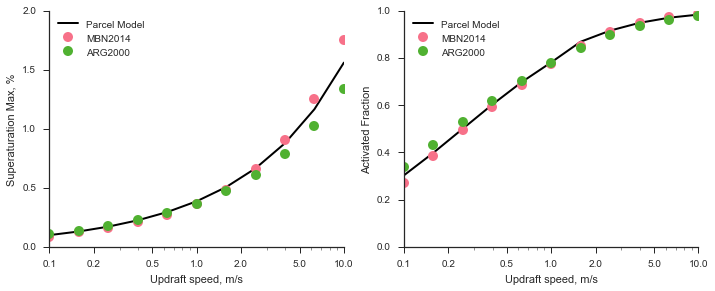

In [11]:
sns.set(context="notebook", style='ticks')
sns.set_palette("husl", 3)
fig, [ax_s, ax_a] = plt.subplots(1, 2, sharex=True, figsize=(10,4))

ax_s.plot(Vs, np.array(smaxes)*100., color='k', lw=2, label="Parcel Model")
ax_s.plot(Vs, np.array(smaxes_mbn)*100., linestyle='None', 
          marker="o", ms=10, label="MBN2014" )
ax_s.plot(Vs, np.array(smaxes_arg)*100., linestyle='None', 
          marker="o", ms=10, label="ARG2000" )
ax_s.semilogx()
ax_s.set_ylabel("Superaturation Max, %")
ax_s.set_ylim(0, 2.)

ax_a.plot(Vs, act_fracs, color='k', lw=2, label="Parcel Model")
ax_a.plot(Vs, act_fracs_mbn, linestyle='None', 
          marker="o", ms=10, label="MBN2014" )
ax_a.plot(Vs, act_fracs_arg, linestyle='None', 
          marker="o", ms=10, label="ARG2000" )
ax_a.semilogx()
ax_a.set_ylabel("Activated Fraction")
ax_a.set_ylim(0, 1.)

plt.tight_layout()
sns.despine()

for ax in [ax_s, ax_a]:
    ax.legend(loc='upper left')
    ax.xaxis.set_ticks([0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
    ax.xaxis.set_ticklabels([0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0])
    ax.set_xlabel("Updraft speed, m/s")